In [21]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [10]:
monthly = pd.read_csv("monthly_features.csv", parse_dates=["Date"], index_col="Date").sort_index()

In [11]:
monthly.head()

,Month_start,Month_end,High,Low,Year,Return_prev_month,Volatility_prev_month,Range_prev_month,MA5d_minus_MA20d,MA3m,...,February,January,July,June,March,May,November,October,September,Label_next_month
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-31,2108.29,2107.39,2130.82,2080.15,2015,-0.000427,0.006810,50.67,4.4405,2086.930000,...,False,False,False,False,False,True,False,False,False,-0.023024
2015-06-30,2111.73,2063.11,2124.20,2057.64,2015,-0.023024,0.007012,66.56,-11.5195,2085.336667,...,False,False,False,True,False,False,False,False,False,0.012718
2015-07-31,2077.42,2103.84,2128.28,2046.68,2015,0.012718,0.007372,81.60,0.5380,2091.446667,...,False,False,True,False,False,False,False,False,False,-0.059989
2015-08-31,2098.04,1972.18,2104.18,1867.61,2015,-0.059989,0.016831,236.57,-85.5915,2046.376667,...,False,False,False,False,False,False,False,False,False,0.003229
2015-09-30,1913.85,1920.03,1995.31,1881.77,2015,0.003229,0.014185,113.54,-36.0360,1998.683333,...,False,False,False,False,False,False,False,False,True,0.080850


In [12]:
X = monthly.drop(columns=["Label_next_month", "Year", "Month_start", "High", "Low", "MA3m", "MA6m"])
y = monthly["Label_next_month"]

In [13]:
print("X shape:", X.shape)  # (115, 18)
print("y shape:", y.shape)  # (115,)
print(X.head())

X shape: (115, 18)
y shape: (115,)
            Month_end  Return_prev_month  Volatility_prev_month  \
Date                                                              
2015-05-31    2107.39          -0.000427               0.006810   
2015-06-30    2063.11          -0.023024               0.007012   
2015-07-31    2103.84           0.012718               0.007372   
2015-08-31    1972.18          -0.059989               0.016831   
2015-09-30    1920.03           0.003229               0.014185   

            Range_prev_month  MA5d_minus_MA20d  MA3m_minus_MA6m  April  \
Date                                                                     
2015-05-31             50.67            4.4405        17.066667  False   
2015-06-30             66.56          -11.5195        14.771667  False   
2015-07-31             81.60            0.5380         2.740000  False   
2015-08-31            236.57          -85.5915       -20.276667  False   
2015-09-30            113.54          -36.0360     

In [14]:
numeric_features = [
    "Month_end", "Return_prev_month", "Volatility_prev_month",
    "Range_prev_month", "MA5d_minus_MA20d", "MA3m_minus_MA6m"
]

month_features = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

scaler = StandardScaler()
X[month_features] = X[month_features].astype(int)

In [15]:
def prepare_sequences(X, y, seq_length=6, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])
    else:
        X.loc[:, numeric_features] = scaler.transform(X[numeric_features])

    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X.iloc[i:i+seq_length].values)
        ys.append(y.iloc[i+seq_length])
    X_seq, y_seq = np.array(xs), np.array(ys)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)

    return X_tensor, y_tensor, scaler

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [17]:
def train_and_evaluate(X_tensor, y_tensor, seq_length, epochs=50, batch_size=16):
    train_size = int(0.8 * len(X_tensor))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    input_size = X_tensor.shape[2]
    model = LSTMModel(input_size=input_size, hidden_size=64)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_true = y_test.numpy()

    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    direction_acc = np.mean((y_pred > 0) == (y_true > 0))

    return rmse, direction_acc, y_true, y_pred

In [18]:
def plot_predictions(y_true, y_pred, test_dates, seq_length):
    plt.figure(figsize=(8, 4))
    plt.plot(test_dates, y_true, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", marker='x')
    plt.title(f"Reality vs Predicted (Seq_length={seq_length})")
    plt.xlabel("Date")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

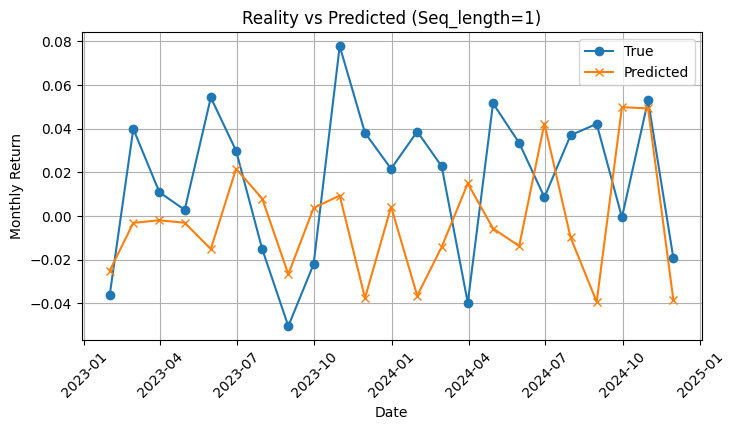

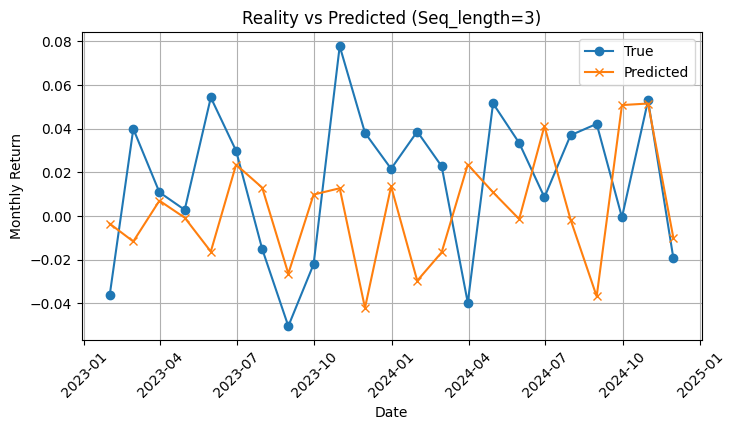

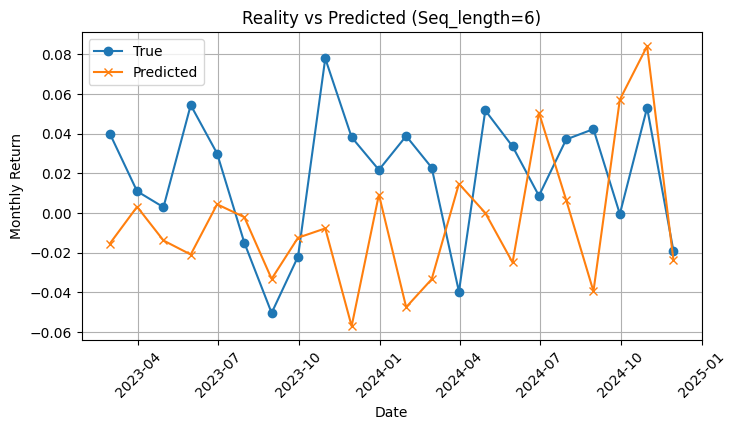

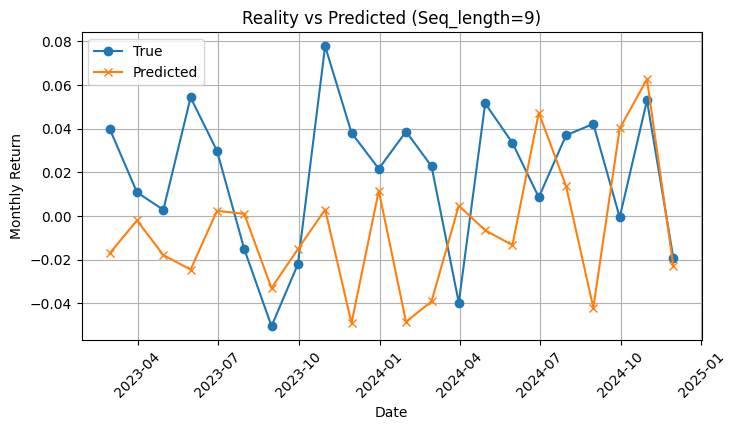

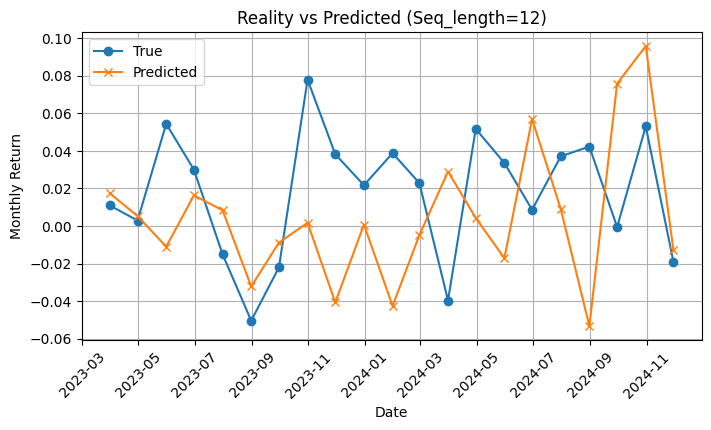

Result：
Seq_length=1: RMSE=0.0457, Direction Accuracy=0.3478
Seq_length=3: RMSE=0.0450, Direction Accuracy=0.4348
Seq_length=6: RMSE=0.0523, Direction Accuracy=0.4545
Seq_length=9: RMSE=0.0498, Direction Accuracy=0.4091
Seq_length=12: RMSE=0.0511, Direction Accuracy=0.5714


In [22]:
results = {}

for seq_len in [1, 3, 6, 9, 12]:
    X_tensor, y_tensor, _ = prepare_sequences(X.copy(), y.copy(), seq_length=seq_len)
    rmse, acc, y_true, y_pred = train_and_evaluate(X_tensor, y_tensor, seq_len)
    results[seq_len] = {"RMSE": rmse, "Direction Accuracy": acc}
    test_dates = X.index[-len(y_true):]
    plot_predictions(y_true, y_pred, test_dates, seq_len)

print("Result：")
for seq_len, metrics in results.items():
    print(f"Seq_length={seq_len}: RMSE={metrics['RMSE']:.4f}, Direction Accuracy={metrics['Direction Accuracy']:.4f}")

In [23]:
X = monthly.drop(columns=["Label_next_month", "Year", "Month_start", "High", "Low", "MA3m", "MA6m"])
y = monthly["Label_next_month"]

In [24]:
numeric_features = [
    "Month_end", "Return_prev_month", "Volatility_prev_month",
    "Range_prev_month", "MA5d_minus_MA20d", "MA3m_minus_MA6m"
]

scaler = StandardScaler()
X[month_features] = X[month_features].astype(int)

In [25]:
# Change hidden_size from 64 to 32
# Add weight decay to avoid overfitting

def train_and_evaluate(X_tensor, y_tensor, seq_length, epochs=100, batch_size=16):
    train_size = int(0.8 * len(X_tensor))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    input_size = X_tensor.shape[2]
    model = LSTMModel(input_size=input_size, hidden_size=32)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_true = y_test.numpy()

    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    direction_acc = np.mean((y_pred > 0) == (y_true > 0))

    return rmse, direction_acc

In [26]:
results = {}
for seq_len in [1, 3, 6, 9, 12]:
    X_tensor, y_tensor, _ = prepare_sequences(X.copy(), y.copy(), seq_length=seq_len)
    rmse, acc = train_and_evaluate(X_tensor, y_tensor, seq_len)
    results[seq_len] = {"RMSE": rmse, "Direction Accuracy": acc}

print("Result：")
for seq_len, metrics in results.items():
    print(f"Seq_length={seq_len}: RMSE={metrics['RMSE']:.4f}, Direction Accuracy={metrics['Direction Accuracy']:.4f}")

Result：
Seq_length=1: RMSE=0.0557, Direction Accuracy=0.5217
Seq_length=3: RMSE=0.0568, Direction Accuracy=0.5652
Seq_length=6: RMSE=0.0633, Direction Accuracy=0.2727
Seq_length=9: RMSE=0.0674, Direction Accuracy=0.3182
Seq_length=12: RMSE=0.0639, Direction Accuracy=0.4286


In [27]:
# Keep MA3m_minus_MA6m and Drop MA5d_minus_MA20d

X = monthly.drop(columns=["Label_next_month", "Year", "Month_start", "High", "Low", "MA3m", "MA6m", "MA5d_minus_MA20d"])
y = monthly["Label_next_month"]

In [28]:
numeric_features = [
    "Month_end", "Return_prev_month", "Volatility_prev_month",
    "Range_prev_month", "MA3m_minus_MA6m"
]

scaler = StandardScaler()
X[month_features] = X[month_features].astype(int)

In [29]:
results = {}
for seq_len in [1, 3, 6, 9, 12]:
    X_tensor, y_tensor, _ = prepare_sequences(X.copy(), y.copy(), seq_length=seq_len)
    rmse, acc = train_and_evaluate(X_tensor, y_tensor, seq_len)
    results[seq_len] = {"RMSE": rmse, "Direction Accuracy": acc}

print("Result：")
for seq_len, metrics in results.items():
    print(f"Seq_length={seq_len}: RMSE={metrics['RMSE']:.4f}, Direction Accuracy={metrics['Direction Accuracy']:.4f}")

Result：
Seq_length=1: RMSE=0.0494, Direction Accuracy=0.4348
Seq_length=3: RMSE=0.0463, Direction Accuracy=0.5652
Seq_length=6: RMSE=0.0550, Direction Accuracy=0.4091
Seq_length=9: RMSE=0.0561, Direction Accuracy=0.3636
Seq_length=12: RMSE=0.0529, Direction Accuracy=0.4762


In [30]:
# Keep MA5d_minus_MA20d and Drop MA3m_minus_MA6m
X = monthly.drop(columns=["Label_next_month", "Year", "Month_start", "High", "Low", "MA3m", "MA6m", "MA3m_minus_MA6m"])
y = monthly["Label_next_month"]

In [31]:
numeric_features = [
    "Month_end", "Return_prev_month", "Volatility_prev_month",
    "Range_prev_month", "MA5d_minus_MA20d"
]

scaler = StandardScaler()
X[month_features] = X[month_features].astype(int)

In [ ]:
results = {}
for seq_len in [1, 3, 6, 9, 12]:
    X_tensor, y_tensor, _ = prepare_sequences(X.copy(), y.copy(), seq_length=seq_len)
    rmse, acc = train_and_evaluate(X_tensor, y_tensor, seq_len)
    results[seq_len] = {"RMSE": rmse, "Direction Accuracy": acc}

print("Result：")
for seq_len, metrics in results.items():
    print(f"Seq_length={seq_len}: RMSE={metrics['RMSE']:.4f}, Direction Accuracy={metrics['Direction Accuracy']:.4f}")